In [1]:
filename = "X:/MSI_Shared_Data/13CImagingManuscript/raw_data/imzmls/20210223_02_100w120h_13CtumorBrain2_009109H_01 009109H_1.imzML" #path to datafile
outfile = "X:/MSI_Shared_Data/13CImagingManuscript/raw_data/imzmls/20210223_02_100w120h_13CtumorBrain2_009109H_01 009109H_1_results.zip"

m0Formula = "C6H12O9P" #formula for M0 ion (with appropriate adduct)
polarity = "negative" #ionization polarity 
ppmThresh = 50 #m/z tolerance, all peaks within ppmThresh ppm will be summed into one feature
convSquare = 1 #size of filter (1=1x1,3=3x3,5=5x5)
colormap = "gray" #coloring for images, see https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
num_cores = 5 #number of processor cores to use
dm_method = "PCA" #method for dimensionality reduction ("PCA" or "TSNE") PCA has worked better for me
seg_method = "K_means" #thresholding method ("TIC_auto", "K_means", "TIC_manual")
num_components = 2 #number of compoents to use with PCA or TSNE
filt = "GB" #filtering method (GB = gaussian blur, MA = moving average)
intensityCutoff = 100 #minimum intensity to keep
dims = (100,120)

In [2]:
#load libraries
import SIMSIToolBox
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import zipfile
import os

In [3]:
#calculate relevant m/z's
m0Mz,mzsOI,numCarbons = SIMSIToolBox.getMzsOfIsotopologues(m0Formula,elementOfInterest="C")
print(mzsOI)

[259.02189396131, 260.02525396131, 261.02861396131, 262.03197396131003, 263.03533396131, 264.03869396131, 265.04205396131]


In [4]:
#read data
if __name__ == "__main__":
    msi = SIMSIToolBox.MSIData(mzsOI,ppm=ppmThresh,numCores = num_cores,intensityCutoff=intensityCutoff)
    if ".imzML" in filename:
        msi.readimzML(filename,dims)
    else:
        msi.readHDIOutput(filename,polarity)
    

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\pyimzml\ontology\ontology.py:94: UserWarning: Accession MS:1000526 found with incorrect name "Waters raw file". Updating name to "Waters raw format".
  % (accession, raw_name, name)
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\pyimzml\ontology\ontology.py:94: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  % (accession, raw_name, name)
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\pyimzml\ontology\ontology.py:94: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  % (accession, raw_name, name)
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\pyimzml\ontology\ontology.py:94: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size". Updating name to "pixel size (x)".
  %

formatting arguments |██------------------------------------------------| 5.0% 

formatting arguments |████----------------------------------------------| 9.8% 

formatting arguments |███████-------------------------------------------| 15.5% 

formatting arguments |██████████----------------------------------------| 20.6% 

formatting arguments |████████████--------------------------------------| 25.6% 

formatting arguments |███████████████-----------------------------------| 30.5% 

formatting arguments |█████████████████---------------------------------| 35.5% 

formatting arguments |███████████████████-------------------------------| 39.9% 

formatting arguments |██████████████████████----------------------------| 44.6% 

formatting arguments |████████████████████████--------------------------| 49.7% 

formatting arguments |███████████████████████████-----------------------| 54.4% 

formatting arguments |█████████████████████████████---------------------| 59.3% 

formatting arguments |████████████████████████████████------------------| 64.6% 

formatting arguments |██████████████████████████████████----------------| 68.9% 

formatting arguments |█████████████████████████████████████-------------| 74.2% 

formatting arguments |███████████████████████████████████████-----------| 78.8% 

formatting arguments |██████████████████████████████████████████--------| 84.1% 

formatting arguments |████████████████████████████████████████████------| 89.5% 

formatting arguments |███████████████████████████████████████████████---| 95.6% 

formatting arguments |██████████████████████████████████████████████████| 100.0% 


extracting intensities |██████████████████████████████████████████████████| 100.0% 


In [9]:
msi.to_imzML(filename.replace(".imzML","_G6P.imzML"))

ValueError: zero-size array to reduction operation minimum which has no identity

Text(0.5, 1.0, 'TIC')

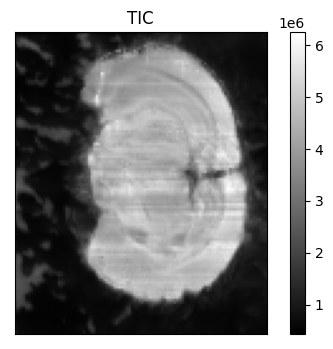

In [5]:
#show TIC image
SIMSIToolBox.showImage(msi.tic_image,cmap=colormap)
plt.title("TIC")

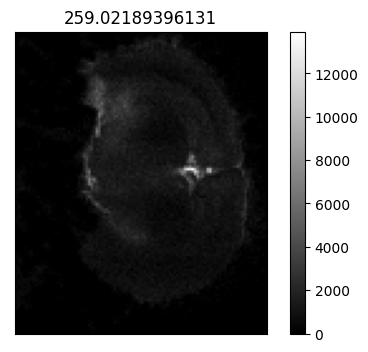

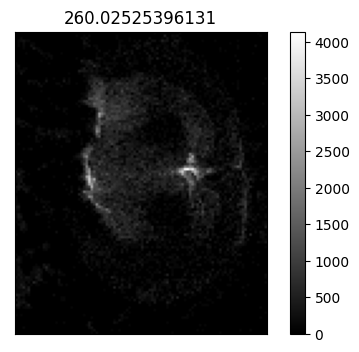

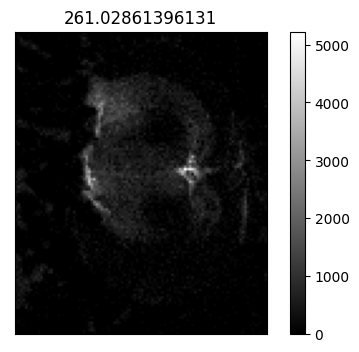

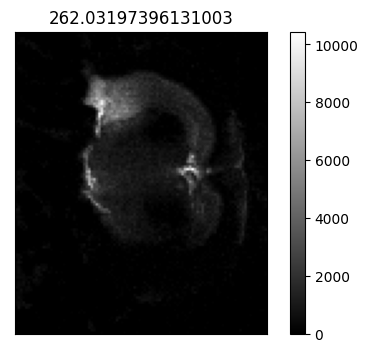

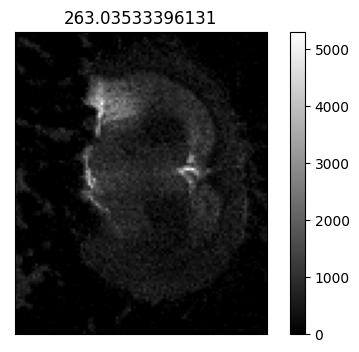

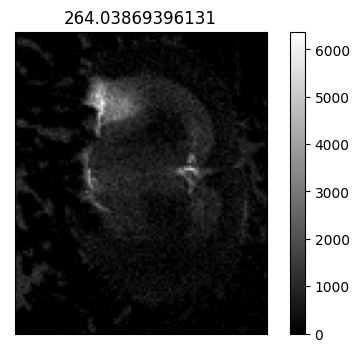

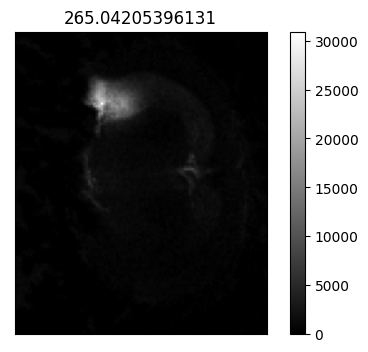

In [6]:
#show images of mzs of interest
for mz,image in zip(msi.targets,msi.data_tensor):
    plt.figure()
    SIMSIToolBox.showImage(image,cmap=colormap)
    plt.title(mz)

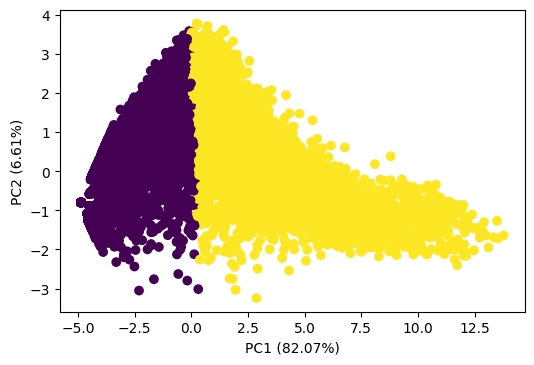

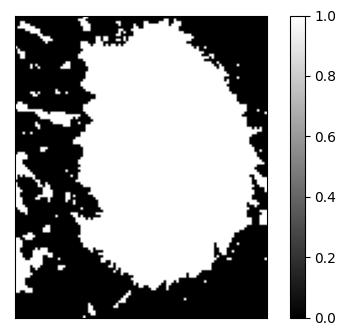

In [7]:
#segment image to remove background
msi.segmentImage(method=seg_method)
plt.figure()
SIMSIToolBox.showImage(msi.imageBoundary,cmap=colormap)

Smoothing data |██████████████████████████████████████████████████| 100.0% 


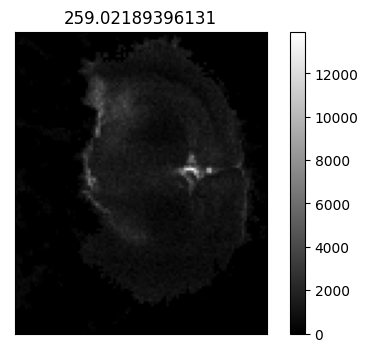

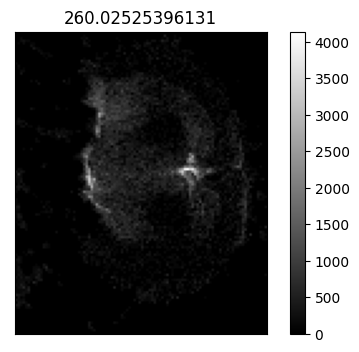

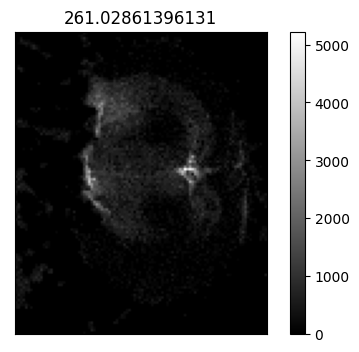

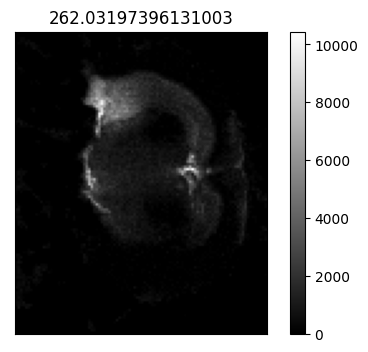

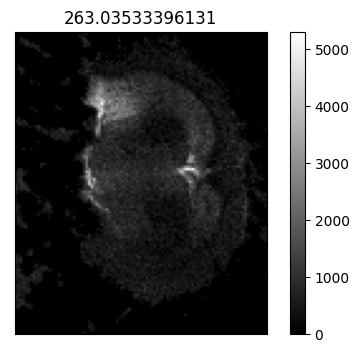

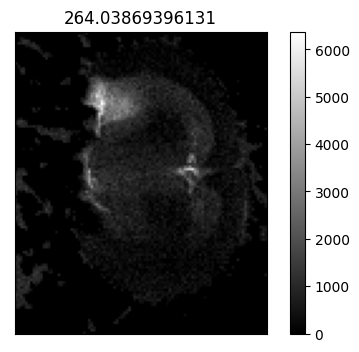

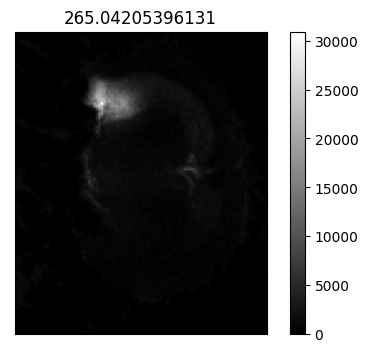

In [8]:
#smooth data and show smoothed result
if __name__ == "__main__":
    msi.smoothData(filt,convSquare)
    for mz,image in zip(msi.targets,msi.data_tensor):
        plt.figure()
        SIMSIToolBox.showImage(image,cmap=colormap)
        plt.title(mz)

In [9]:
if __name__ == "__main__":
    msi.correctNaturalAbundance(m0Formula)

correcting natural abundance |██████████████████████████████████████████████████| 100.0% 


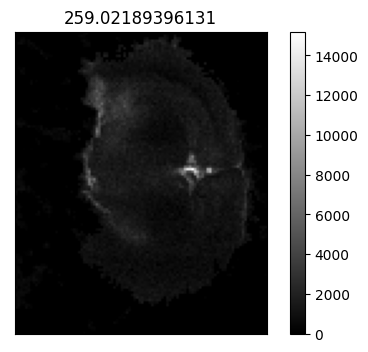

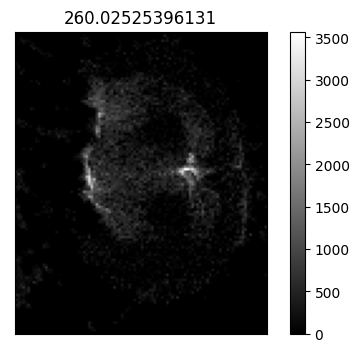

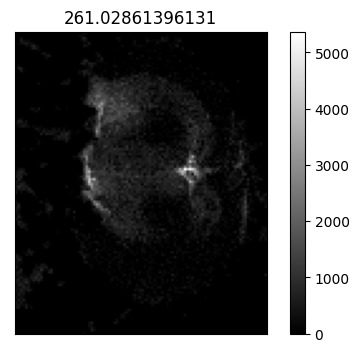

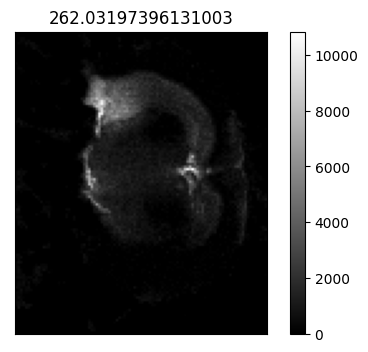

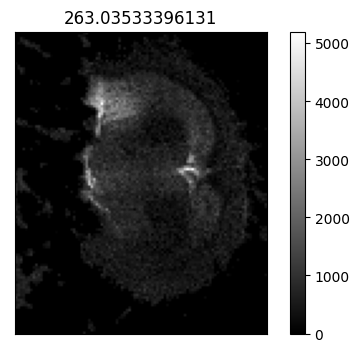

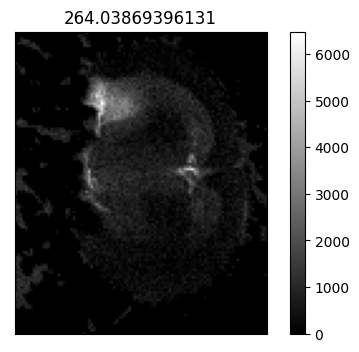

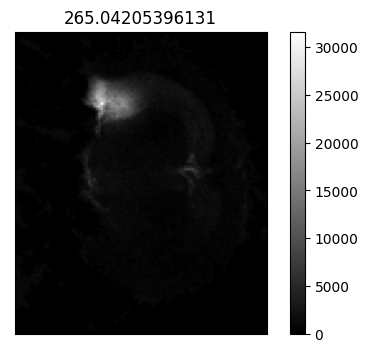

In [11]:
for mz,image in zip(msi.targets,msi.data_tensor):
    plt.figure()
    SIMSIToolBox.showImage(image,cmap=colormap)
    plt.title(mz)

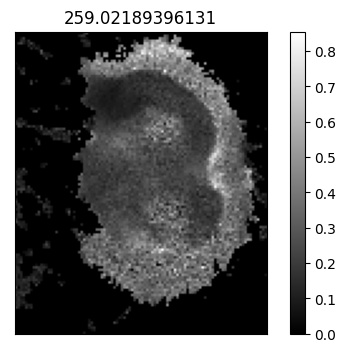

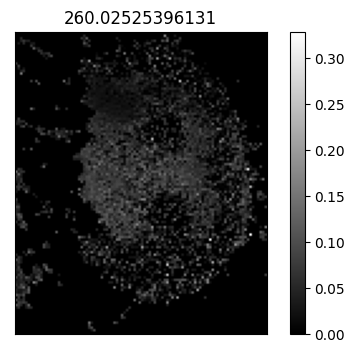

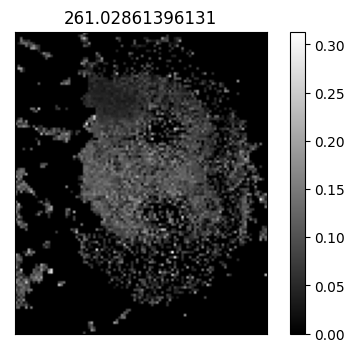

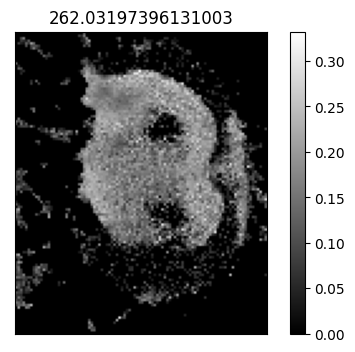

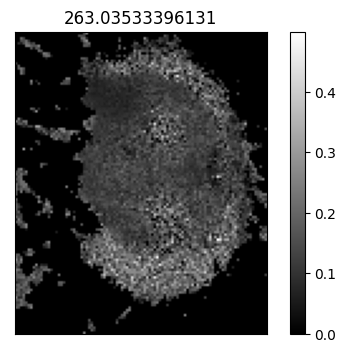

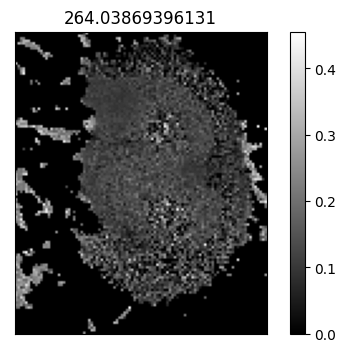

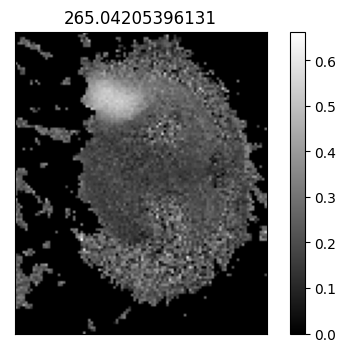

In [12]:
myzip = zipfile.ZipFile(outfile,"w")

#calculation labeling pattern images and save result
iso_tensor = SIMSIToolBox.normalizeTensor(msi.data_tensor)
counter = 0
for mz,image in zip(msi.targets,iso_tensor):
    plt.figure()
    SIMSIToolBox.showImage(image,cmap=colormap)
    plt.title(mz)
    SIMSIToolBox.saveTIF(image,"M" + str(counter) + ".tif")
    SIMSIToolBox.write_file_to_zip(myzip,"M" + str(counter) + ".tif")
    os.remove("M" + str(counter) + ".tif")
    counter += 1

myzip.close()